In [1]:
# IMPORTS
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

In [6]:
# directories
base_dirs = ["./Training", "./Testing"]

# subfolders
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# labels
labels = {'glioma_tumor': 0, 'meningioma_tumor': 0, 'no_tumor': 1, 'pituitary_tumor': 0}

# Assuming images is a list of your loaded images
# Dummy example for generating binary masks for each image
image_labels = []  # This will store the masks
images = []
for base_dir in base_dirs:
    for category in categories:
        category_path = os.path.join(base_dir, category)
        for img_name in os.listdir(category_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Assuming the presence of a tumor (this should be derived from your actual data)
                label_value = labels[category]
                # Create a dummy mask where the entire image is labeled with the presence or absence of a tumor
                mask = np.full((128, 128, 1), label_value, dtype=np.float32)
                image_labels.append(mask)
                img_path = os.path.join(category_path, img_name)
                img = Image.open(img_path)
                img = img.resize((128, 128))  # resize images for uniformity
                img = np.array(img) # convert to array
                images.append(img)

# convert lists to numpy arrays
images = np.array(images)
image_labels = np.array(image_labels)

In [7]:
# U-Net model architecture
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)
    # Downsampling through the model
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Upsampling and establishing the skip connections
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Compile the U-Net model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Split to test vs train
X_train, X_test, y_train, y_test = train_test_split(images, image_labels, test_size=0.2, random_state=42)

# Normalize the images
X_train = X_train / 255.0
X_test = X_test / 255.0

# Fit the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

1/1 [==============================] - 0s 24ms/step


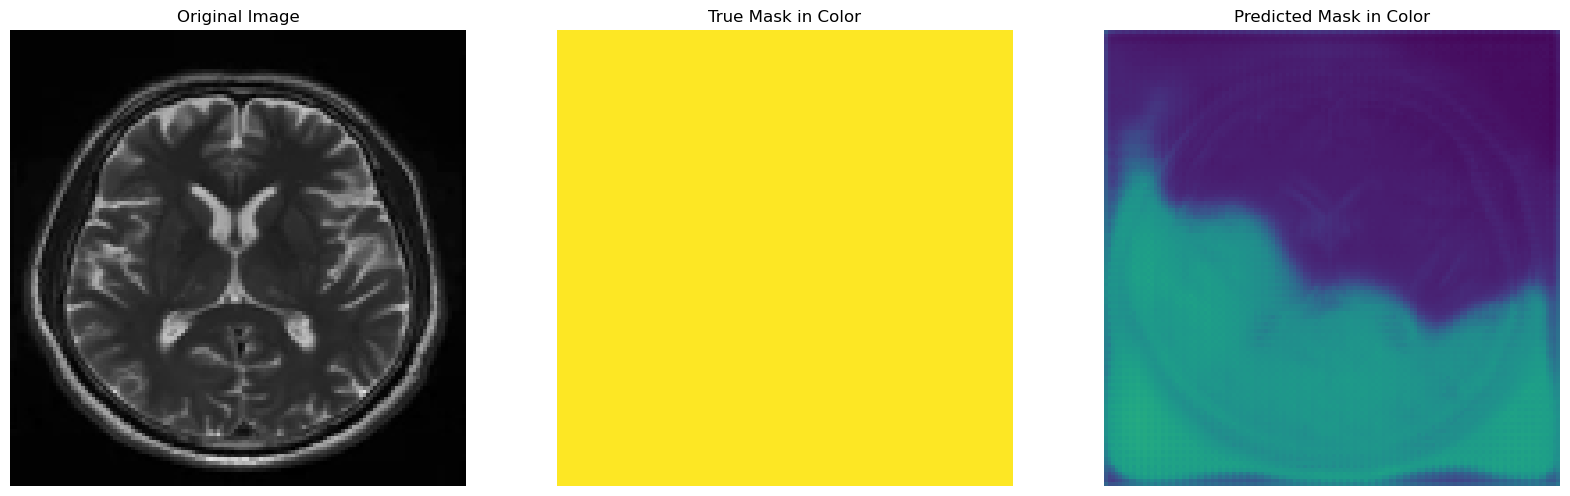

1/1 [==============================] - 0s 23ms/step


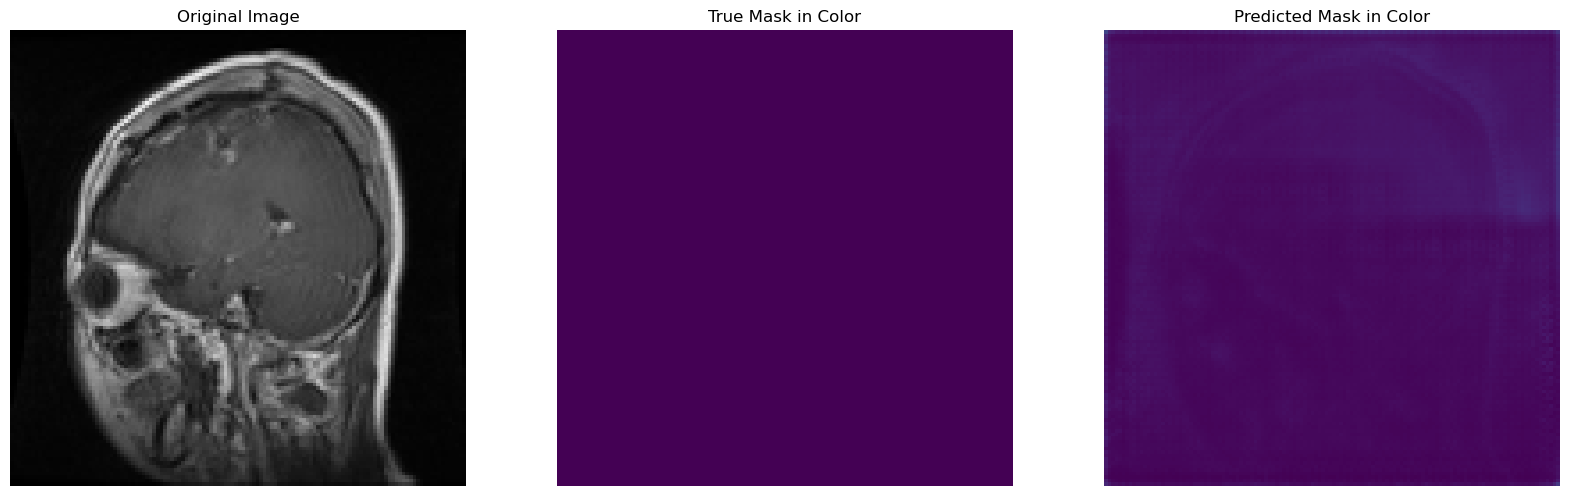

1/1 [==============================] - 0s 21ms/step


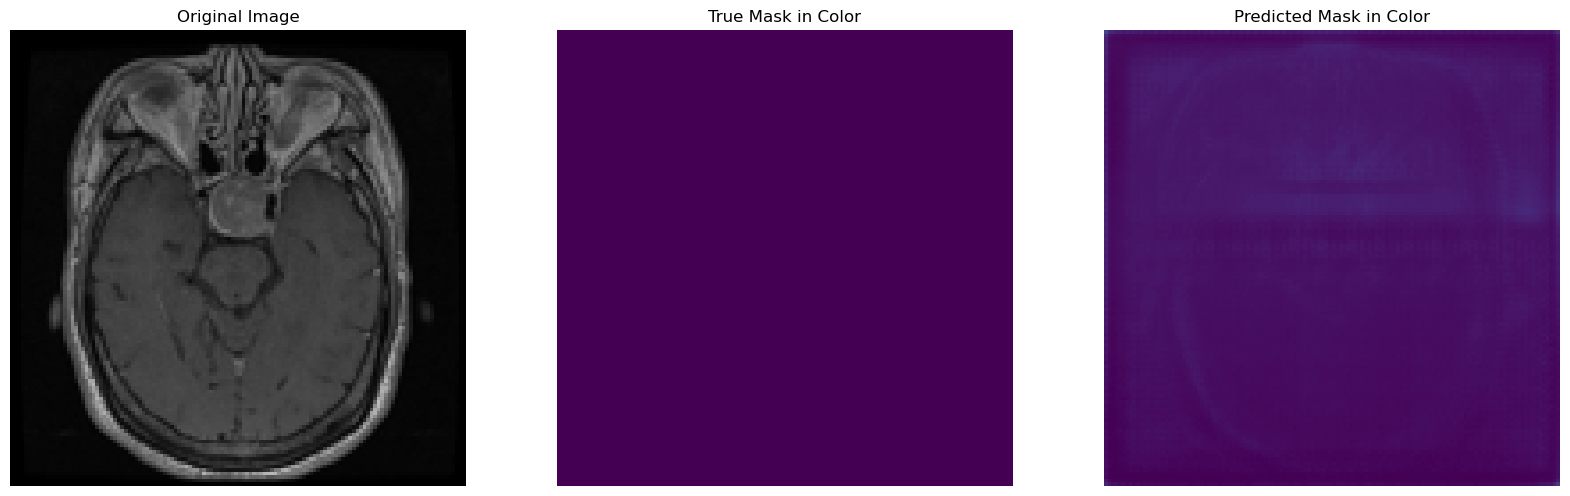

1/1 [==============================] - 0s 23ms/step


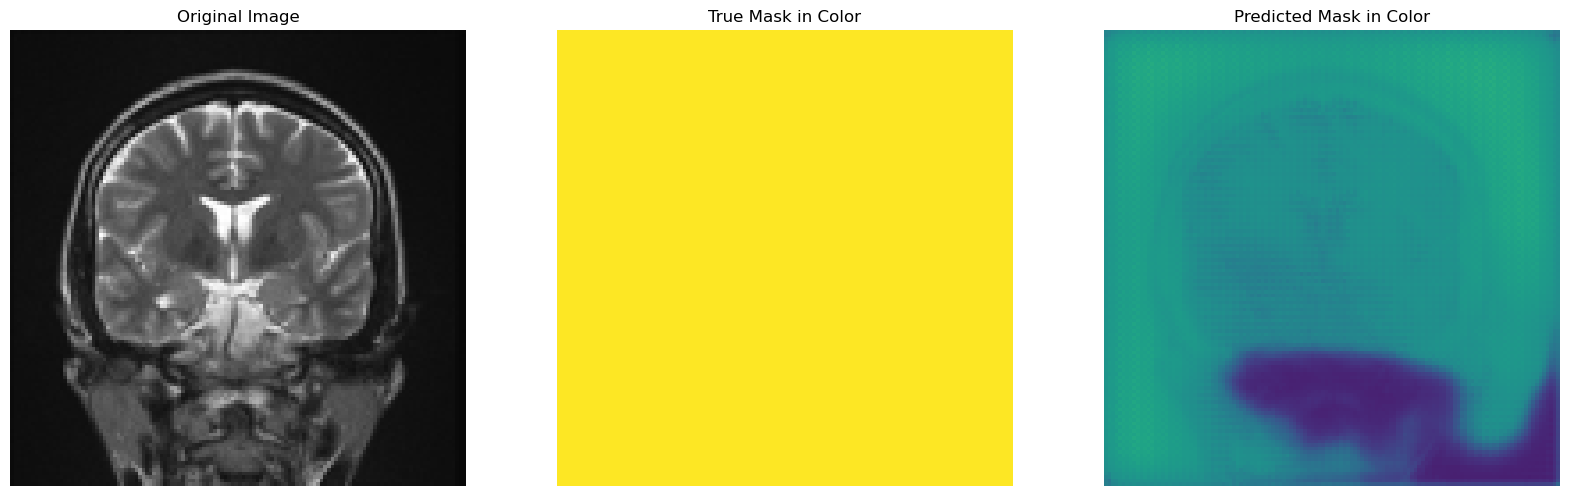

1/1 [==============================] - 0s 23ms/step


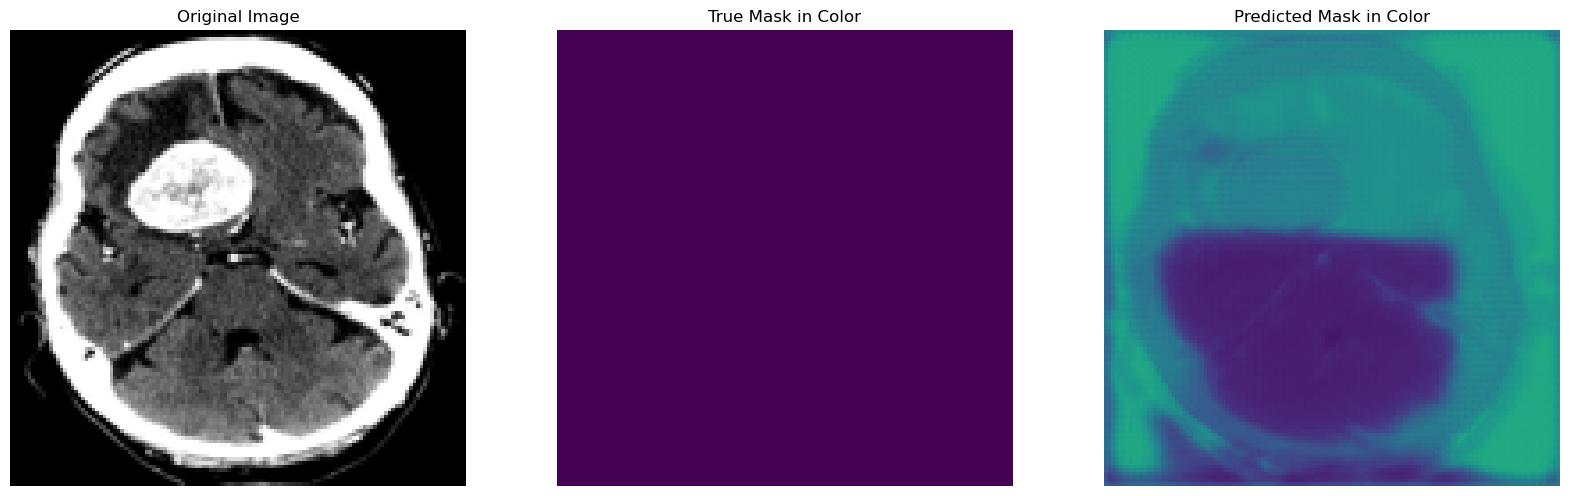

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_predictions_colored(model, X_test, y_test, num_imgs=5):
    """
    Plot a few test images along with their true labels and predicted masks in color.

    Parameters:
    - model: The trained model.
    - X_test: Test images.
    - y_test: True labels/masks for the test images.
    - num_imgs: Number of images to display.
    """
    # Define a colormap, you can choose any suitable matplotlib colormap
    cmap = plt.get_cmap('viridis')
    
    # Randomly select a few images from the test set
    idxs = np.random.choice(range(len(X_test)), num_imgs, replace=False)

    for i, idx in enumerate(idxs):
        img = X_test[idx]
        true_mask = y_test[idx].squeeze()  # Remove channel dimension if it exists
        pred_mask = model.predict(np.expand_dims(img, axis=0)).squeeze()
        
        # Convert binary mask to colored mask using the colormap
        true_mask_colored = cmap(true_mask)[:, :, :3]  # Drop the alpha channel
        pred_mask_colored = cmap(pred_mask)[:, :, :3]  # Drop the alpha channel
        
        # Plotting
        fig, axes = plt.subplots(1, 3, figsize=(20, 10))
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(true_mask_colored)
        axes[1].set_title('True Mask in Color')
        axes[1].axis('off')

        axes[2].imshow(pred_mask_colored)
        axes[2].set_title('Predicted Mask in Color')
        axes[2].axis('off')

        plt.show()

# Assuming X_test, y_test are your test images and labels
plot_model_predictions_colored(model, X_test, y_test, num_imgs=5)
